In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.stats import zscore
from numpy.linalg import svd
from scipy.spatial.distance import pdist, squareform, cdist
from sklearn.manifold import TSNE, SpectralEmbedding,Isomap
from matplotlib.patches import Rectangle,Patch
from matplotlib.collections import LineCollection, PatchCollection
import matplotlib.gridspec as gridspec
%run functions-py.py

In [5]:
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.5g" % x))

In [6]:
suspense=np.load("../Data/avg_suspense.npy")

## Correlation between Salience-Executive-Default

In [7]:
file="../Data/my_rois_net1_ordered.json"
#file="../Data/my_rois_net1_notemp_ordered.json"

In [8]:
networks=['Salience','Frontal-Parietal','Default']
my_dict=regions_from_json(file,networks,verbose=False)
regions=my_dict['array']
lengths=my_dict['length']
r=np.sum(lengths)
print(r)

74


In [9]:
lims=create_limits(lengths)
print(lims)

[0, 10, 30, 74]


In [10]:
# new=list(range(8,47+8)) + list(range(60+8,74+8))
# r=len(new)
# print(new)

### Dynamic correlation

In [11]:
slide=18

In [12]:
sliding_all_og=np.load('../Data/sliding_all_'+str(slide)+'.npy')
sliding_all_og
t_s, r_r = sliding_all_og.shape
print(t_s,r_r)

176 3321


In [13]:
#47--60
new=list(range(8,55))+list(range(68,82))

In [14]:
#sliding_all_og=[squareform(squareform(sliding_all_og[i,:])[np.ix_(new,new)]) for i in range(t_s)]
sliding_all_og=[squareform(squareform(sliding_all_og[i,:])[8:,8:]) for i in range(t_s)]
sliding_all_og=np.array(sliding_all_og)

In [15]:
t_s, r_r = sliding_all_og.shape
print(t_s,r_r)

176 2701


In [16]:
#alpha=find_alpha_by_density(sliding_all_og,alpha=0.36,step=0.01)
alpha=0.37
print(alpha)

0.37


In [17]:
#sliding_all=sliding_all_og
sliding_all=sliding_all_og*(sliding_all_og>alpha)

In [18]:
corr_din=np.zeros((t_s,r,r)) 
for i in range(t_s):
    corr_din[i,:,:]=squareform(sliding_all[i,])

In [19]:
corr_din.shape

(176, 74, 74)

In [20]:
density=np.zeros(t_s)
for i in range(t_s):
    density[i]=np.sum(sliding_all_og[i,:]>alpha)*100/(r_r)

In [21]:
connectness=np.zeros(t_s)
for i in range(t_s):
    connectness[i]=check_connected(squareform(sliding_all_og[i,:]>alpha))

In [22]:
print(min(density))
print(max(density))
print(max(density) - min(density))

32.72861902998889
47.35283228433914
14.624213254350245


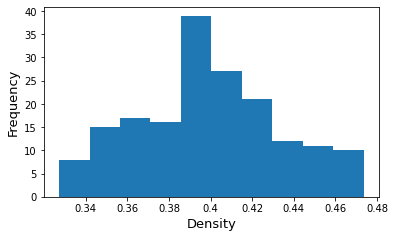

In [23]:
plt.figure(figsize=(6,3.5))
plt.hist(density)
plt.xlabel("Density",fontsize=13)
plt.ylabel("Frequency",fontsize=13)
_=plt.xticks(ticks=np.arange(34,49,2),labels=[str(i) for i in np.arange(34,49,2)/100])
plt.savefig('../Imagenes/thesis/density.pdf',bbox_inches='tight')

In [24]:
connectness

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Text(-0.02, 0.4, 'Default')

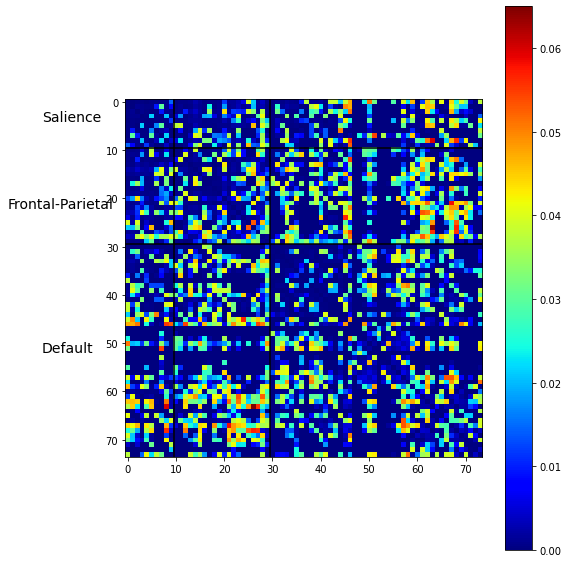

In [25]:
var=np.var(corr_din,axis=0)
np.save('../Data/my_var.npy',var.astype(np.float64))
plt.figure(figsize=(8,10))
plt.imshow(var,cmap=plt.get_cmap('jet'),interpolation='nearest')
plt.colorbar()
l=-1
for i in lengths[:-1]:
    l=l+i
    plt.axvline(x=l+0.5,color='black')
    plt.axhline(y=l+0.5,color='black')
plt.text(-0.02, 0.72, 'Salience', fontsize=14, transform=plt.gcf().transFigure)
plt.text(-0.08, 0.6, 'Frontal-Parietal', fontsize=14, transform=plt.gcf().transFigure)
plt.text(-0.02, 0.4, 'Default', fontsize=14, transform=plt.gcf().transFigure)

### Weights between and within networks

In [26]:
lims

[0, 10, 30, 74]

In [27]:
networks=['Salience','Fronto-Parietal','Default'] #I have to put the name Fronto-parietal
from itertools import combinations_with_replacement
pos_weights={}
for j,k in combinations_with_replacement(range(len(networks)),2):
    name=networks[j]+'/'+networks[k]
    pos_weights[name]=np.zeros(t_s)
    block=corr_din[:,lims[j]:lims[j+1],lims[k]:lims[k+1]]
    for i in range(t_s):
        if j==k:
            pos_weights[name][i]=network_weight(block[i,:,:],alpha=0,inter=False)
        else:
            pos_weights[name][i]=network_weight(block[i,:,:],alpha=0)

In [28]:
y=[np.mean(np.array(suspense[i:i+18])) for i in range(t_s)]

In [29]:
inter_net=len(pos_weights)
corr=np.zeros((inter_net,145))
keys=list(pos_weights.keys())
for i in range(inter_net):
    for j in range(145):
        a1=pos_weights[keys[i]][j:]
        a2=suspense[10:10+t_s][j:]
        #a2=y[89:]
        corr[i,j]=np.corrcoef(zscore(a1),zscore(a2))[0,1]

In [ ]:
#It looks good, the expected correlation with suspense
fig, ax = plt.subplots()
im = ax.imshow(corr)
# We want to show all ticks...
ax.set_yticks(np.arange(inter_net))
ax.set_yticklabels(keys)
plt.colorbar(im)

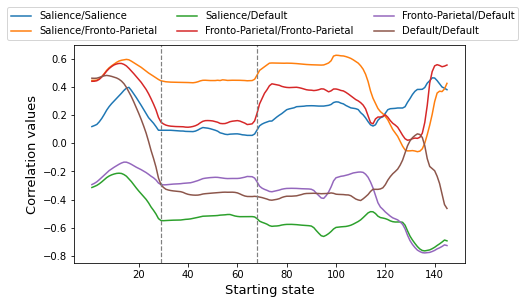

In [30]:
#Plot of correlation values

fig=plt.figure(figsize=(7,4))

keys=list(pos_weights.keys())
#plt.title(keys[i],fontsize=12)
ax = plt.gca()
plt.ylabel('Correlation values',fontsize=13)
label = ax.set_xlabel('Starting state', fontsize = 13)
#ax.xaxis.set_label_coords(-0.05, -0.03)
plt.plot(corr.T)
    
g=20
ticks=np.arange(g-1,159,g)
plt.xticks(ticks=ticks,labels=ticks+1)
#plt.yticks([])
plt.legend(pos_weights.keys(),loc='center right', bbox_to_anchor=(1.15, 1.1),ncol=3)

for i in [28,67]:
    plt.axvline(x=i,color='gray',linestyle='dashed',linewidth=1.2) 
    
#fig.savefig('../Imagenes/thesis/networks_correlations.pdf',bbox_inches='tight')

In [31]:
#[0.092184 0.44315 -0.53989 0.15038 -0.23627 -0.45534]
#print(np.mean(corr[:,28:66],axis=1))
print(corr[:,0])
print(corr[:,28])
print(corr[:,67])
print(corr[:,89])

[0.11846 0.44605 -0.31375 0.43959 -0.29293 0.46145]
[0.092184 0.44315 -0.54789 0.15038 -0.29335 -0.29315]
[0.094242 0.48435 -0.535 0.21396 -0.27413 -0.37811]
[0.26633 0.55682 -0.58737 0.3764 -0.32642 -0.35473]


In [32]:
np.save('../Data/my_corr_28.npy',corr[:,28])

In [33]:
np.arctanh(corr[:,10])

array([0.32914, 0.65314, -0.21719, 0.63624, -0.16062, 0.50135])

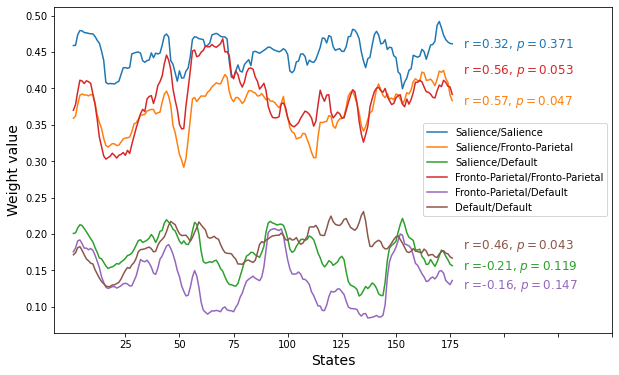

In [34]:
#We plot the graphs with alpha
#We put the corr values with alpha 
positions=[]
fig=plt.figure(figsize=(10,6))
for i in range(len(pos_weights)):
    #plt.subplot(3,2,i+1)
    keys=list(pos_weights.keys())
    #plt.title(keys[i],fontsize=12)
    ax = plt.gca()
    plt.ylabel('Weight value',fontsize=14)
    label = ax.set_xlabel('States', fontsize = 14)
    #ax.xaxis.set_label_coords(-0.05, -0.03)
    plt.plot(pos_weights[keys[i]])
    positions.append(pos_weights[keys[i]][175])
    
g=25
ticks=np.arange(g-1,251,g)
plt.xticks(ticks=ticks,labels=list(ticks[:7]+1) + ['','', ''])
#plt.yticks([])
plt.legend(pos_weights.keys(),loc='center right', bbox_to_anchor=(1, 0.5))

colors= [plt.gca().lines[i].get_color() for i in range(6)]
strings= [str(i) for i in np.round(corr[:,10],2)]
positions2=np.array(positions)-0.005
positions2[3]=0.42
positions2[4]=0.125
positions2[5]=0.18
rhos=[str(i) for i in [0.371, 0.047, 0.119, 0.053, 0.147, 0.043]] 
#plot text
for pos,string,rho,color in zip(positions2,strings,rhos,colors):
    plt.text(180, pos, "r =" + string +", " + r'$p = $' + rho ,fontsize = 12,color=color)
    
fig.savefig('../Imagenes/avance_3/networks_weights.pdf',bbox_inches='tight')

In [27]:
blocks1 = np.array([[1,22],[89,109],[112,145],[146,176]])
blocks2 = np.array([[100,103],[154,163],[165,170]])
blocks3 = np.array([[26,29],[106,108]])
color=['yellow','khaki','lawngreen','turquoise']

In [28]:
my_order=[0,3,1,5,2,4]

In [69]:
np.min(pos_weights['Salience/Salience'])

0.3994212544119511

Text(0.5, 0.98, 'Connectivity weights ... ')

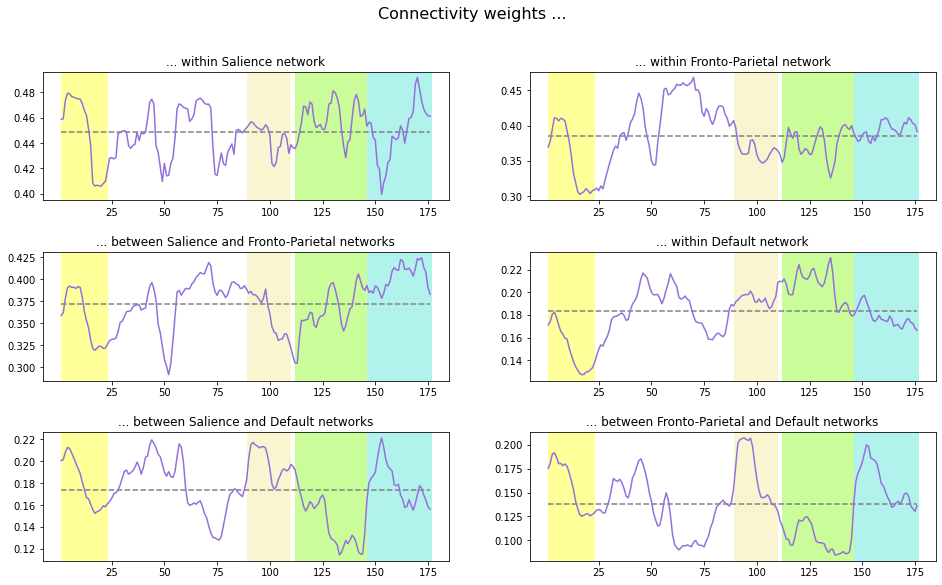

In [70]:
#We plot each of the network weigthts with the blocks of Mapper 
fig = plt.figure(figsize=(16,9))
nrows=3
ncols=2

gs = gridspec.GridSpec(nrows, ncols)
gs.update(wspace=0.2, hspace=0.4) # set the spacing between axes. 

keys=list(pos_weights.keys())

for k in range(len(pos_weights)):
    axs=plt.subplot(gs[k])
    key=keys[my_order[k]]
    avg=my_avg(pos_weights[key],blocks1)
    #plt.plot(avg,color='gray',linestyle='dashed')
    plt.plot([np.mean(pos_weights[key])]*t_s,color='gray',linestyle='dashed')
    plt.plot(pos_weights[key],color='mediumpurple')
    #for i in [15]:
    #    plt.axvline(x=i,color='gray',linestyle='dashed',linewidth=1.2) 

    part=str.split(key,sep= "/")
    if (part[0] == part[1]):
        plt.title('... within ' + part[0]+ ' network')
    else:
        plt.title('... between ' + part[0]+' and ' + part[1] + ' networks')
    
    g=25
    ticks=np.arange(g-1,177,g)
    plt.xticks(ticks=ticks,labels=ticks+1)

    rects1=[]
    block1=blocks1-1
    for i in range(block1.shape[0]):
        rect=Rectangle((block1[i,0],-1.7),block1[i,1]+1-block1[i,0],2.7)
        rects1.append(rect)

    pc1 = PatchCollection(rects1, facecolor=color, alpha=0.4,edgecolor=None)
    axs.add_collection(pc1)

    
fig.suptitle('Connectivity weights ... ',size=16)
#fig.savefig('../Imagenes/thesis/networks_weights.pdf',bbox_inches='tight')

In [30]:
color=['khaki','lawngreen','turquoise']

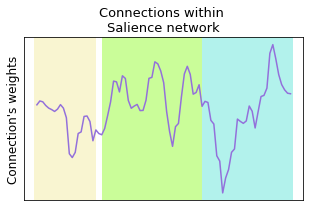

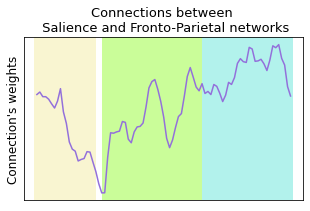

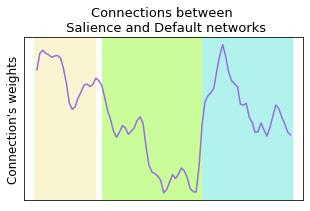

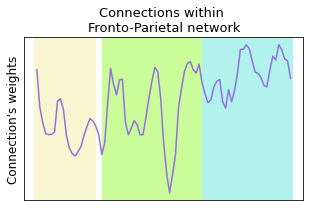

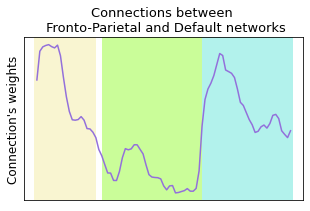

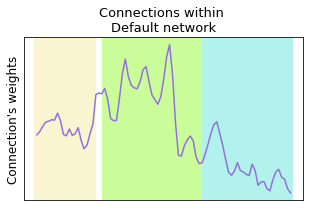

In [31]:
# Same blocks but just khaki, green and blue blocks
keys=list(pos_weights.keys())

for k in range(6):
    fig, axs = plt.subplots(figsize=(5,3))
    key=keys[k]
    #plt.plot(avg,color='gray',linestyle='dashed')
    #plt.plot([np.mean(pos_weights[key])]*t_s,color='gray',linestyle='dashed')
    plt.plot(pos_weights[key][89:89+87],color='mediumpurple')
    #for i in [15]:
    #    plt.axvline(x=i,color='gray',linestyle='dashed',linewidth=1.2) 

#     g=25
#     ticks=np.arange(100,180,g)
#     plt.xticks(ticks=ticks-90,labels=ticks)
    plt.xticks([])
    plt.yticks([])
    
    part=str.split(key,sep= "/")
    if (part[0] == part[1]):
        plt.title('Connections within \n' + part[0]+ ' network',fontsize=13)
    else:
        plt.title('Connections between \n ' + part[0]+' and ' + part[1] + ' networks',fontsize=13)
        
    plt.ylabel("Connection's weights",fontsize=12)

    rects1=[]
    block1=blocks1[1:]-90
    for i in range(block1.shape[0]):
        rect=Rectangle((block1[i,0],-1.7),block1[i,1]+1-block1[i,0],2.7)
        rects1.append(rect)

    pc1 = PatchCollection(rects1, facecolor=color, alpha=0.4,edgecolor=None)
    axs.add_collection(pc1)

    #fig.suptitle('Connectivity weights ... ',size=16)
    fig.savefig('../Imagenes/thesis/networks_weights_'+part[0]+'_'+part[1]+'.pdf',bbox_inches='tight')